# Exercise 1: Time series analysis and forecasting

## 0. Venv Install using pip 
Upgrade pip and install usefull libraries. %%capture to avoid printing boring stuff

In [1]:
%%capture
'''%pip install -U pip
%pip install pandas
%pip install matplotlib
%pip install statsmodels
%pip install -U scikit-learn
%pip install ipywidgets
%pip install jupyterlab_widgets
%pip install seaborn
%pip install plotly
%pip install scipy
%pip install --upgrade pmdarima
%pip install numpy==1.26.4'''

### <span style="color:red">Note: you need to install jupyter widgets (by using the following line or from the side bar) and restart the web page </span>

In [2]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#%pip install jupyterlab-link-share

## 1. Import useful libraries
Import libraries:
1. **Pandas**, **math** and **numpy** for data manipulation and handling datasets
2. **Matplotlib**, **seaborn** and **plotly** for creating visualizations
3. **Statsmodels** and **pmdarima** for testing basic statistical models
5. **Scikit-learn** for crossvalidation, model evaluation and assessment
6. **Ipywidgets** to interact with the user
7. Some **local modules**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ipywidgets as widgets
from IPython.display import display, Markdown
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from plotting_func import location3D, quantity_trends, quantity_forecast, outliers_plotting_mean, outliers_plotting_interpolation
from support_func import trim_outliers, pivot_weekday, combined_weekly_stats
from models import model_auto_arima, model_auto_arima_cross

## 2. Import dataset
Use panda to read the .csv as a dataframe and check the structure - columns, data types etc.

In [4]:
df = pd.read_csv('./Data/forecast_data.csv')
df.head()

,location_id,delivery_date,quantity1,latitude,longitude,is_event
0,2884,2024-06-26,2,45.71072,10.04755,1
1,2884,2024-06-27,0,45.71072,10.04755,0
2,2884,2024-06-28,0,45.71072,10.04755,0
3,2884,2024-06-29,0,45.71072,10.04755,0
4,2884,2024-06-30,0,45.71072,10.04755,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347162 entries, 0 to 347161
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   location_id    347162 non-null  int64  
 1   delivery_date  347162 non-null  object 
 2   quantity1      347162 non-null  int64  
 3   latitude       347162 non-null  float64
 4   longitude      347162 non-null  float64
 5   is_event       347162 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 15.9+ MB


## 3. Data Preprocessing
Due to the dataset's large size and the potential lack of sorting, organize the data by id_location and delivery_date to ensure consistent ordering.

In [6]:
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
df = df.sort_values(['location_id', 'delivery_date']).reset_index(drop=True)
df.head()

,location_id,delivery_date,quantity1,latitude,longitude,is_event
0,2884,2024-06-26,2,45.71072,10.04755,1
1,2884,2024-06-27,0,45.71072,10.04755,0
2,2884,2024-06-28,0,45.71072,10.04755,0
3,2884,2024-06-29,0,45.71072,10.04755,0
4,2884,2024-06-30,0,45.71072,10.04755,0


Create two new DataFrames: one for weekly volumes and another for weekday volumes. 
Remove any columns unrelated to the forecasting process, and add columns indicating the week number and day of the week.

In [7]:
df['week_number'] = df['delivery_date'].dt.isocalendar().week
df['weekday'] = df['delivery_date'].dt.day_name()
df['delivery_date']=df['delivery_date'].dt.strftime('%m-%d')
df_withoutGEO = df.drop(columns=['latitude', 'longitude'])
df_withoutGEO

,location_id,delivery_date,quantity1,is_event,week_number,weekday
0,2884,06-26,2,1,26,Wednesday
1,2884,06-27,0,0,26,Thursday
2,2884,06-28,0,0,26,Friday
3,2884,06-29,0,0,26,Saturday
4,2884,06-30,0,0,26,Sunday
...,...,...,...,...,...,...
347157,14821,10-18,4,1,42,Friday
347158,14825,10-18,4,1,42,Friday
347159,14833,10-18,7,1,42,Friday
347160,14834,10-18,5,1,42,Friday


In [8]:
weekly_data = df_withoutGEO.groupby(['location_id', 'week_number']).agg({
    'quantity1': 'sum', 
    'is_event': 'sum'   
}).reset_index()

daily_data = df_withoutGEO.groupby(['location_id', 'weekday']).agg({
    'quantity1': 'sum',
    'is_event': 'sum'
}).reset_index()

In [9]:
print("Weekly Data:")
weekly_data.head()

Weekly Data:


,location_id,week_number,quantity1,is_event
0,2884,26,2,1
1,2884,27,0,0
2,2884,28,3,1
3,2884,29,0,0
4,2884,30,0,0


In [10]:
print("Weekday Total Data:")
daily_data.head(7)

Weekday Total Data:


,location_id,weekday,quantity1,is_event
0,2884,Friday,0,0
1,2884,Monday,10,4
2,2884,Saturday,0,0
3,2884,Sunday,0,0
4,2884,Thursday,0,0
5,2884,Tuesday,0,0
6,2884,Wednesday,11,5


In [11]:
event_data_filtered = df_withoutGEO[df_withoutGEO['is_event'] == 1]
specific_data = event_data_filtered[(event_data_filtered['location_id'] == 3719) & (event_data_filtered['weekday'] == 'Monday')]
display(specific_data['quantity1'].describe())
weekly_stats = event_data_filtered.groupby(['location_id', 'weekday'])['quantity1'].agg(['mean', 'var']).reset_index()
print("Weekday Mean and Variance (when events occur):")
weekly_stats.head()

count     13.000000
mean     134.538462
std       90.416274
min       47.000000
25%       55.000000
50%      120.000000
75%      202.000000
max      331.000000
Name: quantity1, dtype: float64

Weekday Mean and Variance (when events occur):


,location_id,weekday,mean,var
0,2884,Monday,2.5,0.333333
1,2884,Wednesday,2.2,0.200000
2,2885,Monday,8.0,2.461538
3,2886,Friday,6.0,NaN
4,2886,Monday,8.4,0.488889


In [12]:
display(Markdown("### Enter the POS ID to pivot:"))
location_ids = df['location_id'].unique()
location_ids_str = [str(id) for id in location_ids]
ID = widgets.Dropdown(
    options=location_ids_str,
    value='2885',
    description='ID:',
    disabled=False,
)
ID

### Enter the POS ID to pivot:

Dropdown(description='ID:', index=1, options=('2884', '2885', '2886', '2888', '2889', '2890', '2891', '2892', …

<module 'matplotlib.pyplot' from 'C:\\Users\\Tomma\\PycharmProjects\\Time_series_Cargo_ful\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

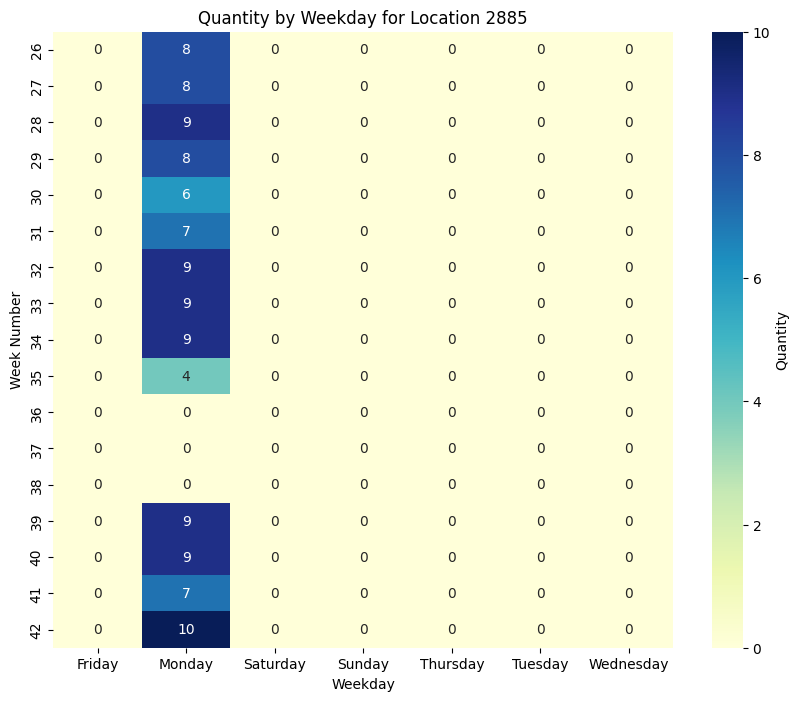

In [13]:
#Pivot
location_id_filter=ID.value
pivot=pivot_weekday(df_withoutGEO,location_id_filter)

#Heatmap
pivot.set_index('week_number', inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Quantity'})
plt.xlabel('Weekday')
plt.ylabel('Week Number')
plt.title(f'Quantity by Weekday for Location {location_id_filter}')
plt

## 4. Data exploration

### 4.1 Data Distributions
Grouping the data by POS will help visualize the total days, events, and quantities associated with each location.
An additional metric for assessing dataset quality could be the percentage of event and non-event days recorded, as well as events per day, for each POS.

In [14]:
# Group by location_id
grouped = df.groupby('location_id')

days_recorded = grouped.size()  # Number of days recorded foreach POS
events_count = grouped['is_event'].sum()  # Total number of events foreach POS
total_events = events_count.sum()
total_days = days_recorded.sum()
total_quantity = grouped['quantity1'].sum() # Quantity volumes foreach POS
event_percentage = events_count/days_recorded * 100  # Percentage of events foreach POS
zero_event_percentage = (1 - event_percentage / 100) * 100  # Percentage of non-events foreach POS
events_per_day = events_count / days_recorded # CEvents per day

summary_df = pd.DataFrame({
    'total_quantity': total_quantity,
    'days_recorded': days_recorded,
    'events_count': events_count,
    'event_percentage': event_percentage,
    'zero_event_percentage': zero_event_percentage,
    'events_per_day': events_per_day
}).reset_index()
summary_df

,location_id,total_quantity,days_recorded,events_count,event_percentage,zero_event_percentage,events_per_day
0,2884,21,115,9,7.826087,92.173913,0.078261
1,2885,112,117,14,11.965812,88.034188,0.119658
2,2886,90,117,11,9.401709,90.598291,0.094017
3,2888,17,110,7,6.363636,93.636364,0.063636
4,2889,185,116,14,12.068966,87.931034,0.120690
...,...,...,...,...,...,...,...
3419,14821,4,1,1,100.000000,0.000000,1.000000
3420,14825,4,1,1,100.000000,0.000000,1.000000
3421,14833,7,1,1,100.000000,0.000000,1.000000
3422,14834,5,1,1,100.000000,0.000000,1.000000


Analysis insights:

- Certain POS have only a single record, making them less suitable for forecasting.
- On average, there are about **<span style="color:red; font-size:18px;">3 months</span>** of data per POS, with events comprising roughly 10% of each period (quite low).
- A valuable additional analysis could be the geo-spatial distribution of recorded quantities and events, which could help prioritize POS based on activity levels.

<span style="color:red"> Note: The dataset consider up to 3 months, so, the forecasting will be quite cripple, since a complete forecasting of a week or a weekday of a specific week should consider the 'average' seasonality of the year.</span>

We further summarize the DataFrame to examine boundaries and mean values for the totals.
Since some POS locations have only a single data point, we applied the IQR method to trim outliers in event and non-event percentages (min, max, and average).

In [15]:
# Trim outliers with IQR method for event_percentage and zero_event_percentage
event_percentage_trimmed = trim_outliers(event_percentage)
zero_event_percentage_trimmed = trim_outliers(zero_event_percentage)

# Max, Min and Mean for summary statistics
summary_stats = {
    'total_quantity': total_quantity,
    'days_recorded': days_recorded,
    'events_count': events_count,
    'event_percentage': event_percentage_trimmed,
    'zero_event_percentage': zero_event_percentage_trimmed,
    'events_per_day': events_per_day
}

summary_list = []

for stat_name, stat_values in summary_stats.items():
    summary_list.append({
        'Statistic': stat_name,
        'Max': stat_values.max(),
        'Min': stat_values.min(),
        'Average': stat_values.mean()
    })

summary_df = pd.DataFrame(summary_list)
summary_df

,Statistic,Max,Min,Average
0,total_quantity,2964.000000,1.000000,70.768107
1,days_recorded,117.000000,1.000000,101.390771
2,events_count,74.000000,1.000000,10.271320
3,event_percentage,26.367659,0.854701,9.832652
4,zero_event_percentage,99.145299,73.632341,90.167348
5,events_per_day,1.000000,0.008547,0.103179


As previously mentioned, analyzing the geo-spatial distribution of quantities and events could provide valuable insights.
This approach helps identify regions with higher or lower activity levels, both in terms of quantities and events.
Additionally, it may reveal data tracking gaps in certain boundary regions, as indicated by earlier metrics.

In [16]:
df_GEO = df.groupby('location_id').agg(
    days_recorded=('delivery_date', 'size'),  
    events_count=('is_event', 'sum'),            
    quantity=('quantity1', 'sum'),                
    latitude=('latitude', 'first'),              
    longitude=('longitude', 'first')
).reset_index()

In [17]:
figure = location3D(df_GEO)
figure.show(renderer="iframe_connected")

The data clearly shows a concentration of flows in the central area compared to other regions.
This suggests that POS in central areas should be prioritized for forecasting, as the higher volume of events there could yield more accurate forecasts. 
Additionally, we might consider applying different forecasting methods for high-priority and low-priority POS, depending on the volume of available data and events for each.

### 4.2 Quantity volumes over time for specific POS IDs
Since we have a big boy here, prompt the user to select up to x POS location IDs to visualize quantity flow activities.

In [18]:
ID_tags = widgets.TagsInput(
    value=('3719', location_ids_str[1]),
    allow_duplicates=False,
    placeholder='es. 2885',
)
display(Markdown("### Enter the POS IDs to visualize:"),ID_tags)

### Enter the POS IDs to visualize:

TagsInput(value=['3719', '2885'], allow_duplicates=False, placeholder='es. 2885')

For each entered POS ID, the quantities for the period, weekly and weekday totals are visualized.
The weekday data is particularly interesting, as it can highlight the weekdays with no events.

,Location_3719_mean,Location_3719_var,Location_2885_mean,Location_2885_var
weekday,,,,
Monday,134.538462,8175.102564,8.0,2.461538
Wednesday,141.250000,2035.583333,-,-
Thursday,94.500000,5731.9,-,-
Friday,83.000000,-,-,-


<module 'matplotlib.pyplot' from 'C:\\Users\\Tomma\\PycharmProjects\\Time_series_Cargo_ful\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

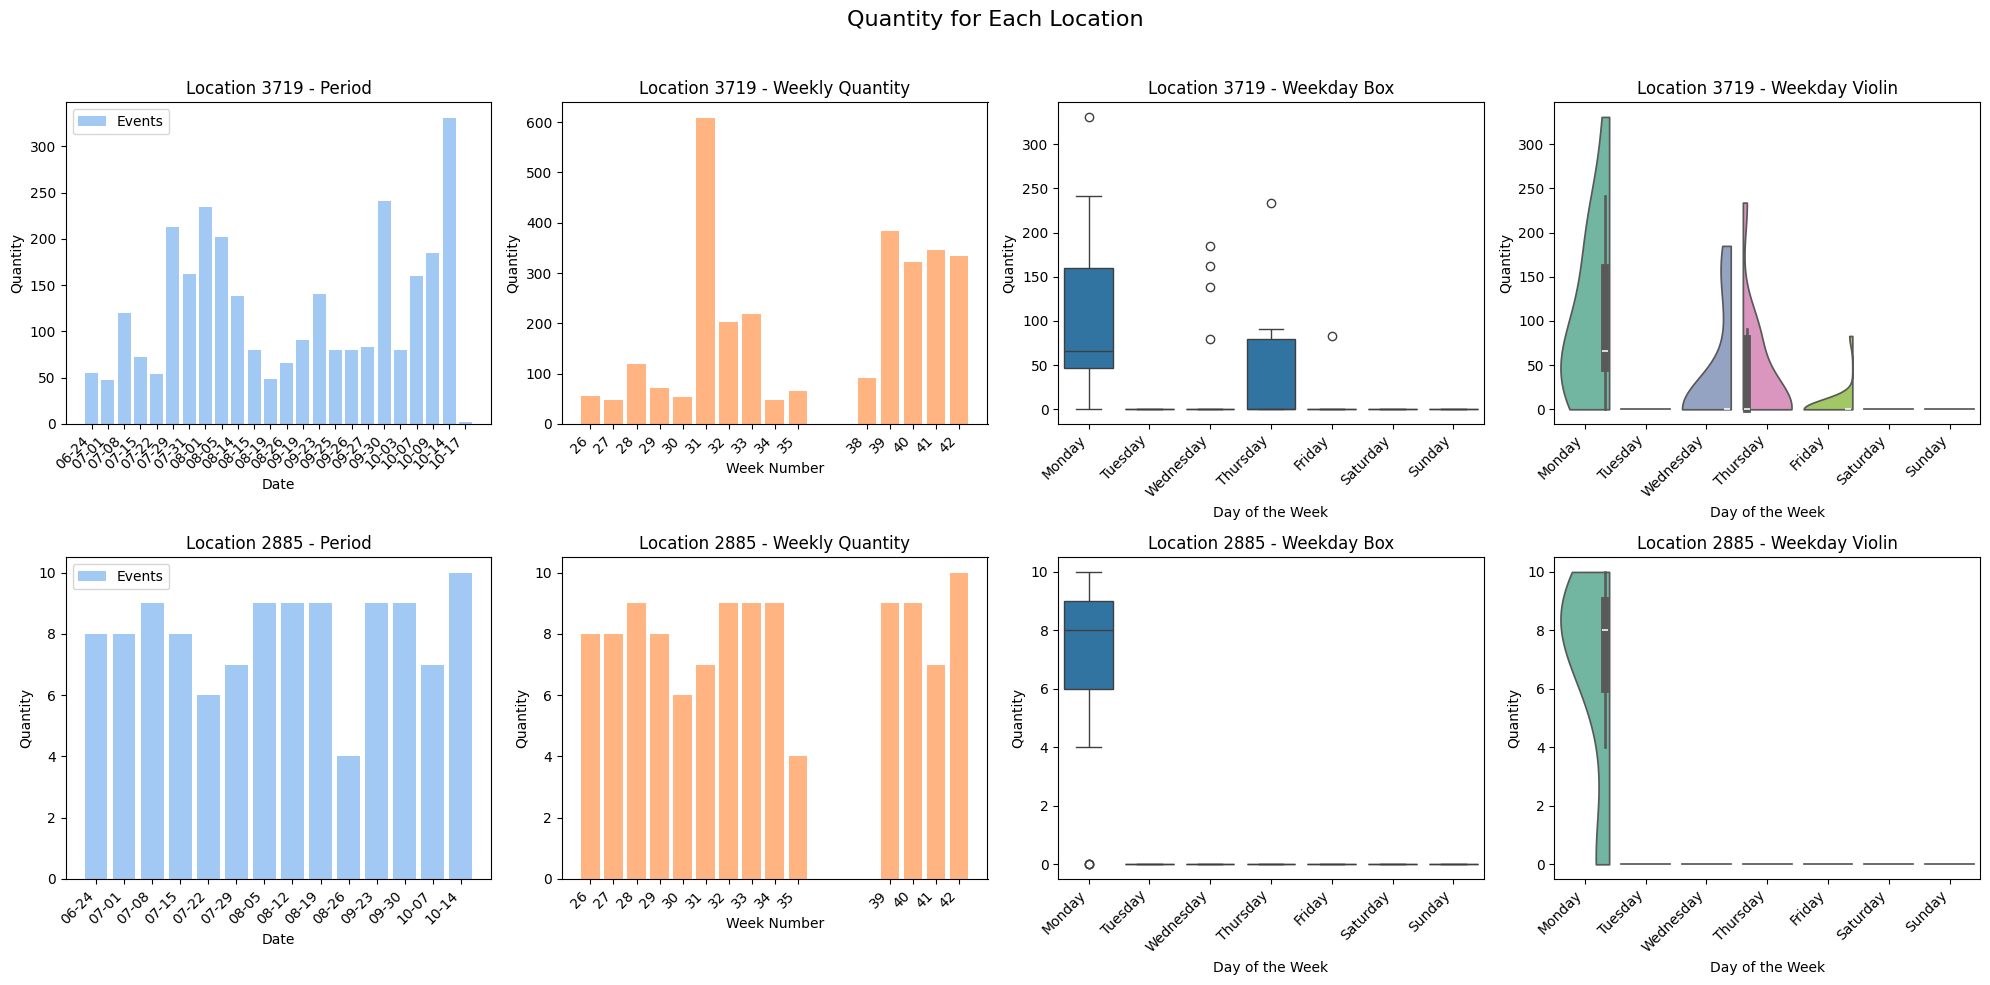

In [19]:
locations_selected = ID_tags.value
plt_quantity = quantity_trends(locations_selected, df, weekly_data, daily_data, df_withoutGEO)
combined_stats_df = combined_weekly_stats(locations_selected, weekly_stats)
display(combined_stats_df)
plt_quantity

### 4.3 Anomaly Detection: Removing outliers using IQR and STL

Let's consider the POS ID ```3719```. 
To address outliers, we’ll analyze weekly volumes rather than daily values. 
Weekly cumulative volumes provide a more reliable measure, as individual daily outliers might still result in weekly totals exceeding acceptable thresholds.

<span style="color: lightblue;">**QUESTION:** Is <code>Zero</code> a valid quantity? Or is it an error?</span>

<span style="color:red"> Note: Since our goal is to forecast weekly volumes, using weekly data is directly aligned with forecasting goals. It captures the patterns and trends in weekly demand.</span>

In [20]:
df_3719 = df_withoutGEO[df_withoutGEO['location_id'].astype(str) == '3719']
df_3719_week = df_3719.groupby('week_number')['quantity1'].sum().reset_index()

display(df_3719_week)
display(Markdown(f"### Old shape: {df_3719_week.shape}"))

,week_number,quantity1
0,26,55
1,27,47
2,28,120
3,29,72
4,30,54
5,31,609
6,32,202
7,33,218
8,34,48
9,35,66


### Old shape: (17, 2)

### 4.3.1: IQR method

Some weekly volumes appear to be outliers (e.g. week 31 -> 609, 36 -> 0), which could negatively impact the ML model's generalization. 
To identify these outliers, we’ll calculate the upper and lower percentiles as thresholds.
In the standard IQR method, the coefficient used to multiply the IQR is typically  ```1.5```. In our case, we’ll adjust this coefficient to  ```1```.

In [21]:
# Upper and lower quartile
Q1 = df_3719_week['quantity1'].quantile(0.25)
Q3 = df_3719_week['quantity1'].quantile(0.75)

# Interquartile range
IQR = Q3 - Q1
lower = Q1 - IQR
if lower < 0:
    lower=0
upper = Q3 + IQR

#lower = Q1 - 1.5 * IQR
#upper = Q3 + 1.5 * IQR

table = f"""
| Metric                 | Value        |
|------------------------|--------------|
| **Q1 (25th percentile)**| {int(Q1)}    |
| **Q3 (75th percentile)**| {int(Q3)}    |
| **Interquartile Range (IQR)** | {int(IQR)} |
| **Lower Bound**         | {int(lower)} |
| **Upper Bound**         | {int(upper)} |
"""
display(Markdown(table))


| Metric                 | Value        |
|------------------------|--------------|
| **Q1 (25th percentile)**| 54    |
| **Q3 (75th percentile)**| 321    |
| **Interquartile Range (IQR)** | 267 |
| **Lower Bound**         | 0 |
| **Upper Bound**         | 588 |


Now, we have two options for dealing with outliers:

1. **Remove the Outliers**: Not ideal here, as the dataset is already small, and removing data could lead to information loss.

2. **Replace Outliers with Smooth Values**:
   - **Mean**: Use the mean of the column.
   - **Interpolation**: Estimate values based on surrounding data.

We'll apply **mean substitution** for the IQR approach and **interpolation** for the TSL.

<module 'matplotlib.pyplot' from 'C:\\Users\\Tomma\\PycharmProjects\\Time_series_Cargo_ful\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

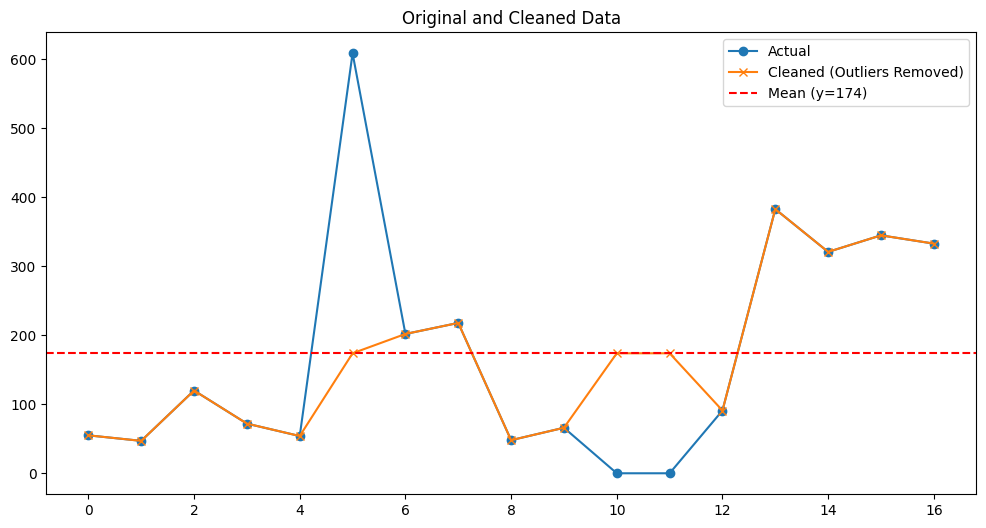

In [22]:
# Identify the outliers
df_3719_week_IQR = df_3719_week.copy()

outliers_lower = df_3719_week_IQR[df_3719_week_IQR['quantity1'] <= lower].index
outliers_upper = df_3719_week_IQR[df_3719_week_IQR['quantity1'] >= upper].index

df_3719_week_IQR['cleaned_quantity1'] = df_3719_week['quantity1'].copy()

# Calculate the mean and replace outliers
mean_quantity1 = int(df_3719_week_IQR['quantity1'].mean())
df_3719_week_IQR.loc[outliers_lower, 'cleaned_quantity1'] = mean_quantity1
df_3719_week_IQR.loc[outliers_upper, 'cleaned_quantity1'] = mean_quantity1

fig_outliers_IQR = outliers_plotting_mean(df_3719_week_IQR['quantity1'], df_3719_week_IQR['cleaned_quantity1'], mean_quantity1)
fig_outliers_IQR

### 4.3.2: STL Method

The **STL** method is another interesting technique for detecting outliers by decomposing the time series data into three key components:

1. **Trend**: The long-term movement over time.
2. **Seasonality**: The repeated fluctuations that occur at fixed intervals (e.g., daily, monthly, yearly).
3. **Residuals**: The remaining component after removing trend and seasonality, representing the random noise or outliers in the dataset.

However, in our context, due to the small datasets, the STL method may be too OP.

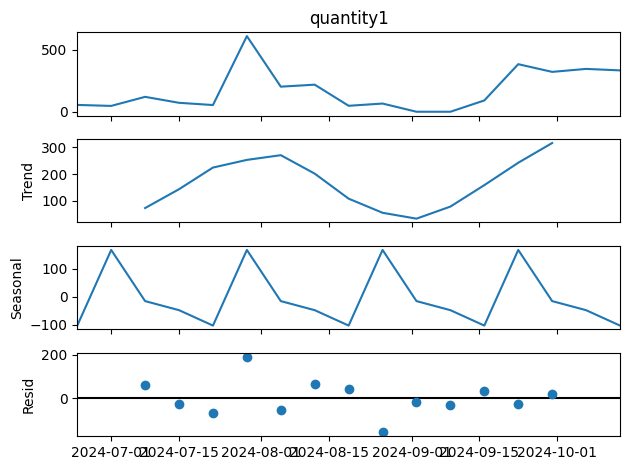

In [23]:
df_3719_week['year'] = 2024
df_3719_week['delivery_date'] = pd.to_datetime(df_3719_week['year'].astype(str) + df_3719_week['week_number'].astype(str) + '1', format='%G%V%u')
df_3719_week = df_3719_week.set_index('delivery_date')

result = seasonal_decompose(df_3719_week['quantity1'], model='additive', period=4)
fig = result.plot()

In [24]:
residuals = result.resid
threshold = 1 * residuals.std()
outliers = np.abs(residuals) > threshold
outliers

delivery_date
2024-06-24    False
2024-07-01    False
2024-07-08    False
2024-07-15    False
2024-07-22    False
2024-07-29     True
2024-08-05    False
2024-08-12    False
2024-08-19    False
2024-08-26     True
2024-09-02    False
2024-09-09    False
2024-09-16    False
2024-09-23    False
2024-09-30    False
2024-10-07    False
2024-10-14    False
Name: resid, dtype: bool

In [25]:
df_3719_week['cleaned_quantity1'] = df_3719_week['quantity1'].copy()
df_3719_week.loc[outliers, 'cleaned_quantity1'] = np.nan
display(df_3719_week[['quantity1','cleaned_quantity1']])

# Fill NaN values by interpolating or by using mean values
df_3719_week['cleaned_quantity1'] = df_3719_week['cleaned_quantity1'].interpolate()

,quantity1,cleaned_quantity1
delivery_date,,
2024-06-24,55,55.0
2024-07-01,47,47.0
2024-07-08,120,120.0
2024-07-15,72,72.0
2024-07-22,54,54.0
2024-07-29,609,NaN
2024-08-05,202,202.0
2024-08-12,218,218.0
2024-08-19,48,48.0


<module 'matplotlib.pyplot' from 'C:\\Users\\Tomma\\PycharmProjects\\Time_series_Cargo_ful\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

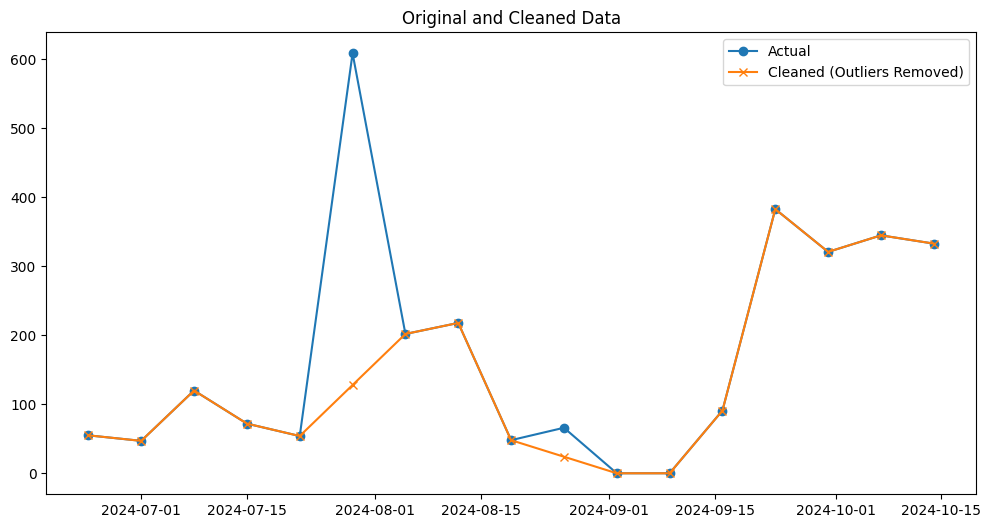

In [26]:
fig_outliers = outliers_plotting_interpolation(df_3719_week['quantity1'], df_3719_week['cleaned_quantity1'])
fig_outliers

## 5. ARIMA (AUTO) Forecasting Algorithm & KPIs Assessment

With the dataset now cleaned of outliers, we’ll proceed with applying a general ARIMA algorithm. ARIMA and SARIMA are widely used ML models for time series forecasting. While ARIMA focuses on autoregressive and moving average components based on past values, SARIMA extends this by incorporating seasonality patterns, using specific parameters (p, d, q) for each period.

Here's a brief overview of the components:

- Autoregressive (AR): In an autoregression model, the forecasted variable is estimated as a linear combination of its past values.
- Moving Average (MA): In a moving average model, past forecast errors (rather than past values) are used, with weights assigned to historical forecast errors.
  
Note:
1. SARIMA may be excessive for this dataset, as its smaller size and limited timeframe do not reveal clear seasonal patterns.
2. I initially considered cross-validation but decided against it due to the dataset's limited size, which would reduce the reliability of the cross-validated estimates.

In [27]:
#%%capture
#<<<<<if you'd like to use IQR dataset>>>>>>>>>
'''df_3719_week_IQR.index = df_3719_week.index
df_3719_week_IQR = df_3719_week_IQR.drop(columns=['quantity1','week_number'])
df_3719_week_IQR.rename(columns={'cleaned_quantity1': 'quantity1'}, inplace=True)
df_3719_week=df_3719_week_IQR.copy()'''

# <<<<<<if you'd like to use TSL datatest>>>>>>>>
df_3719_week = df_3719_week.drop(columns=['quantity1','week_number', 'year'])
df_3719_week.rename(columns={'cleaned_quantity1': 'quantity1'}, inplace=True)


df_3719_week.index = pd.DatetimeIndex(df_3719_week.index)

In [28]:
weeks_to_forecast=5
splitting=5

# Without crossvalidation
forecast = model_auto_arima(df_3719_week, weeks_to_forecast)

# With crossvalidation (not recomended due to benchmark size)
#model_auto_arima_cross(df_3719_week, weeks_to_forecast, splitting)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=213.687, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=228.905, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=208.248, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=218.098, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=209.881, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=209.890, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=211.881, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=207.767, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=216.857, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=208.515, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=208.880, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=209.903, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=209.087, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.173 seconds
Forecast for the next periods:
2024

The performance of the auto-ARIMA model may not be exceptional, but it is reasonable given the dataset size.

1. **Hyperparameter Tuning (AIC Criterion)**:  
   The best parameters for the model, determined using the AIC criterion, are (p, d, q) = (1, 0, 0). The lowest AIC value achieved was **207.767**, indicating a relatively good fit.

2. **Variance (σ²)**:  
   The estimated variance is **8019.9982**, which is quite high. This suggests there is considerable uncertainty in the model’s predictions (the model has not fully captured the patterns in the data).

3. **Root Mean Squared Error (RMSE)**:  
   The **RMSE** is **91.16**, which is quite reasonable. A lower RMSE would indicate a better fit to the training data.

4. **Ljung-Box Q**:  
   The **Q statistic** is **0.81**, which is relatively low. This indicates that there is little evidence of significant autocorrelation in the residuals, suggesting that the model has adequately captured the temporal dependencies in the data.

<span style="color:red">Note: Ideal residuals are uncorrelated (no pattern). This means the model has captured all the underlying structure of the data, and the residuals are just random noise.</span>

6. **P-value of the Ljung-Box Test**:  
   The **p-value** is **0.37**, which is much higher than the typical significance threshold of **0.05**. This means that we fail to reject the null hypothesis, which support the previous observation (no autocorrelation).

7. **Log-Likelihood**:  
   The **log-likelihood** value is useful for model comparison, with higher values indicating better fit.

In summary, while the auto-ARIMA model may not have provided the best possible performance, the results are reasonable, and the model seems to adequately capture the underlying structure of the data.


## 7. Historical Quantities + Forecasted

The ARIMA model results show limited accuracy.

In the plots below, the first plot presents the forecasted volumes for the next 5 weeks, displayed at the tail end of the historical data series. The second plot includes an approximate confidence interval, providing an estimated range for daily volumes during this forecast period.

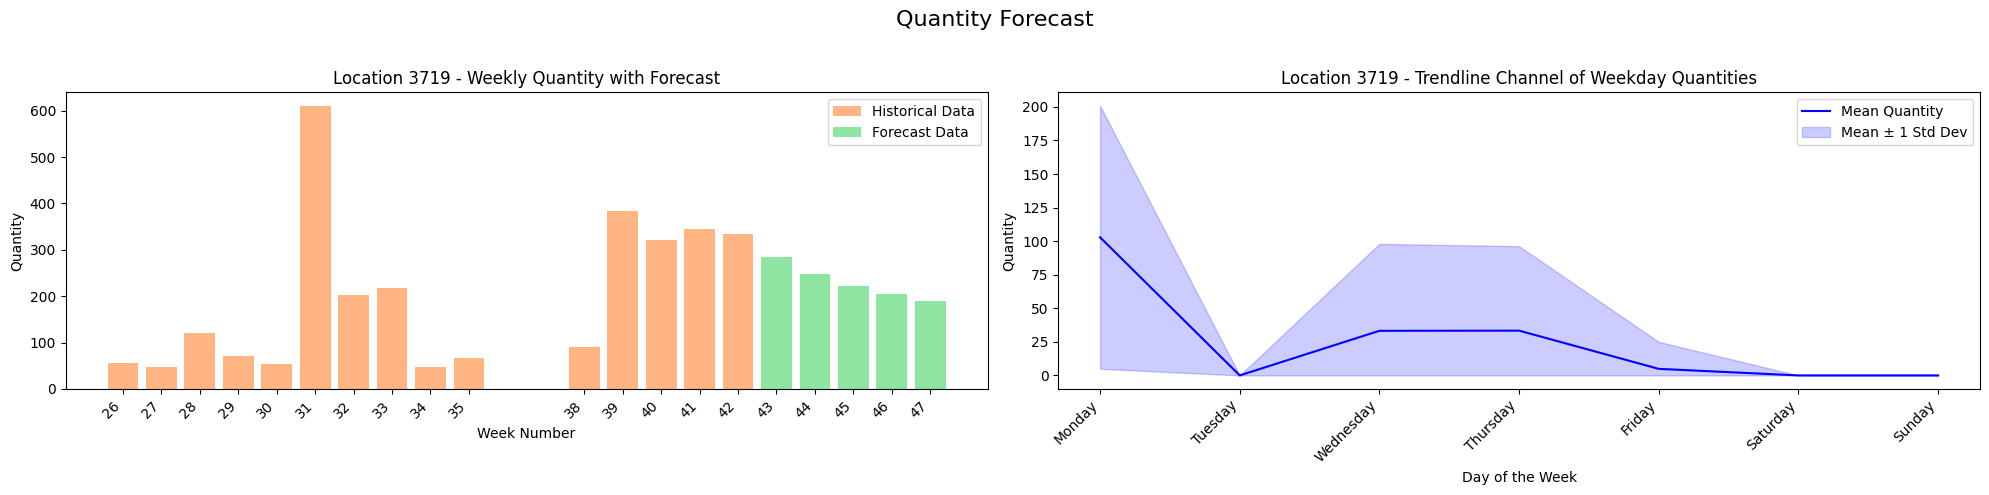

In [29]:
quantity_forecasted = quantity_forecast('3719', weekly_data, daily_data, df_withoutGEO, forecast)